# Building a deep learning framework

In this notebook, you will build a deep learning framework from scratch. Ten exercises will guide you through the implementation of the basic features, but you are encouraged to implement more advanced features on your own. The table below explains how your work will be graded.

### Important information
 - You can work in teams of up to three students.
 - Communication between different teams is forbidden.
 - You must send us this notebook before the oral presentation.
 - The notebook must be fully executed without any error.
 
### Grading

| Exercise | Topic | Points |
|----------|------|--------|
| [Quiz  1](#Quiz-1) | Softmax | 1,25 |
| [Quiz  2](#Quiz-2) | Dense layer | 1,25 |
| [Quiz  3](#Quiz-3) | Initialization | 1,25 |
| [Quiz  4](#Quiz-4) | Two-layer network | 1,25 |
| [Quiz  5](#Quiz-5) | One-hot encoding | 1,25 |
| [Quiz  6](#Quiz-6) | Cross entropy | 1,25 |
| [Quiz  7](#Quiz-7) | Training | 1,25 |
| [Quiz  8](#Quiz-8) | Prediction | 1,25 |
| [Quiz  9](#Quiz-9) | Mini-batches | 1,00 |
| [Quiz 10](#Quiz-10) | Handwritten digit recognition | 1,00 |
| [Quiz 11](#Quiz-11) | Multilayer neural network | 4,00 |
| [Quiz 12](#Quiz-12) | Convolutional neural network | 4,00 |

## Required packages

For this assignment, you need to import the following packages.
- [**Numpy**](www.numpy.org) - The library for scientific computing in Python.
- [**Matplotlib**](http://matplotlib.org) - The library for plotting graphs in Python.
- [**Autograd**](https://github.com/HIPS/autograd) - The library for automatic differentiation of Numpy code.
- [**OpenCV**](https://opencv.org/) - The library aimed at real-time computer vision.
- [**Scikit-Learn**](http://scikit-learn.org/stable/) - Library for data mining and machine learning.

*Run the following cell.*

---

**Installation:** Autograd is not included in the standard Python installation. Open the terminal (Anaconda prompt on Windows) and execute the command:

```
pip install autograd
```

If you are not the admin, add the flag `--user` for a local installation, and **restart the notebook**.

---

**Installation:** OpenCV is not included in the standard Python installation. The simplest way to install it is to open a termina and run the commands:

> `pip install opencv-python`

**If and only if** the previous command fails, you can locally install the precompiled binaries as follows.

- Go to [pypi](https://pypi.org/) or [this page](https://www.lfd.uci.edu/~gohlke/pythonlibs/#pygame), search for **opencv-python**, and download the wheel file (`.whl` extension).

- Select the most recent version of the wheel, according to the operative system and the python version installed on your computer!

- Unzip the wheel with [7zip](https://www.7-zip.org/).

- Find the folder `cv2`, and copy it into  the same folder as this notebook.

In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from numpy.testing import assert_almost_equal

## Introduction

A machine learning system is trained rather than being explicitly programmed. It’s presented with many examples relevant to a task, and it finds the statistical structure in these examples that eventually allows the system to come up with rules for automating the task. In this regard, all machine learning algorithms consist of automatically finding transformations that turn data into more useful representations for a given task. These operations can be linear projections, translations, nonlinear functions, and so on. Deep learning is a specific subfield of machine learning that puts an emphasis on learning successive layers of increasingly meaningful representations through a model called neural network. You can think of a neural network as a multistage "information distillation" operation, where information goes through successive filters, and comes out increasingly purified with regard to some task. That's what machine learning is all about: searching for useful representations of some input data, within a predefined set of operations, which are learned by exposure to many examples of a given task. Now let’s look at how this learning happens, concretely.

<!--![](../images/deep.png)-->

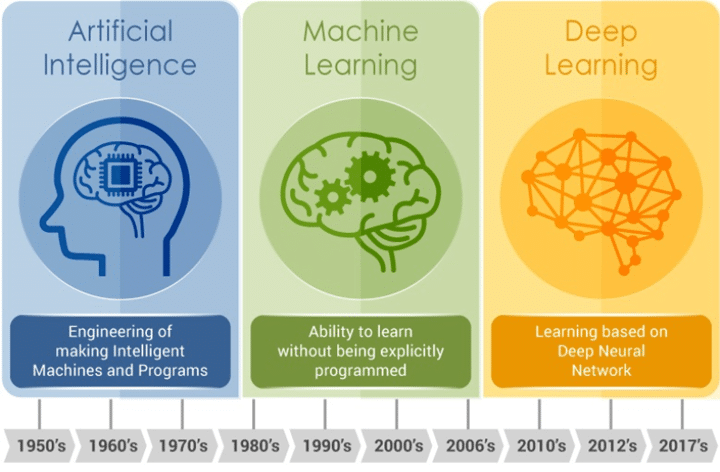

## Multiclass classification

In machine learning, classification is the problem of classifying instances into one of several classes. 

- You are given a set of input-output pairs 
$$
\begin{aligned}
\\
\mathcal{S} = \big\{({\rm x}_n, c_n) \in \mathbb{R}^{N_{\rm input}}\times\{1,\dots,N_{\rm output}\} \;|\; n=1,\dots,N_{\rm samples}\big\}\\
\\
\end{aligned}
$$
where the vector ${\rm x}_n$ represents an instance to be classified, and the associated label $c_n$ represents the class to which it actually belongs. 


- Your goal is to learn a neural network that is capable not only of mapping the vectors ${\rm x}_n$ to their correct classes $c_n$, but also to predict the classes of never-seen-before vectors.

The next figure shows a toy dataset of $N_{\rm samples}=150$ vectors in a space of $N_{\rm input}=2$ dimensions divided in $N_{\rm output}=3$ classes. Here, the points ${\rm x}_n$ colored blue have the label $c_n=1$, those colored red have the label $c_n=2$, and those colored green have the label $c_n=3$.

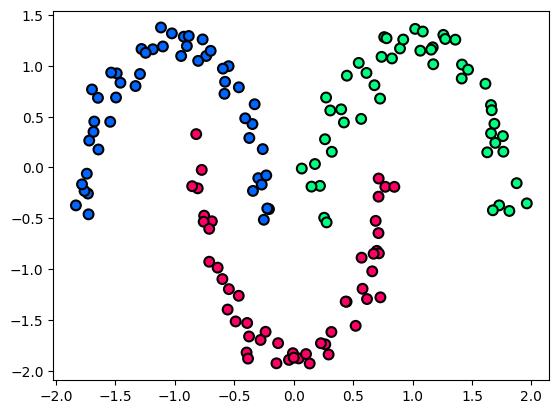

In [2]:
from data.moon import generate_data, show_data

X, c = generate_data()

show_data(X,c)

## Layer

The building block of a neural network is the layer, which can be thought of as a filter for the data. Some layers are stateless, but more frequently layers have a state represented by a bunch of numbers called *parameters* or *weights*. The transformation implemented by a stateful layer is parameterized by its weights.

<!--![](../images/layer.png)-->

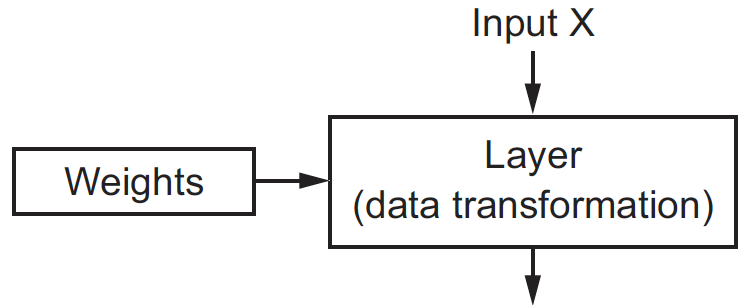

### Implementation details

The layer takes as input one or more vectors, stacked as rows of a matrix. The size of this matrix is equal to the number of vectors ($N_{\rm samples}$) by the length of each vector ($N_{\rm features}$) at the layer input.

$$
X = 
\begin{bmatrix}
\vdots\\
\_\!\_\; {\rm x}_n^\top \_\!\_ \\
\vdots\\
\end{bmatrix}
\in\mathbb{R}^{N_{\rm samples}\times N_{\rm features}}
$$

The layer is parameterized by a weight matrix and a bias vector. The size of the weight matrix is equal to the length of each vector at the layer input ($N_{\rm features}$) by the number of units in the layer ($N_{\rm units}$), and the latter is also the length of the bias vector ${\rm b}$. The number of units is arbitrarly chosen by the user. 

$$
W = 
\begin{bmatrix}
| & & |\\[-1em]
{\rm w}_1 & \dots & {\rm w}_{N_{\rm units}}\\
| & & |\\
\end{bmatrix}
\in\mathbb{R}^{N_{\rm features}\times N_{\rm units}}
\qquad\qquad
{\rm b} = 
\begin{bmatrix} 
b_1 & \dots & b_{N_{\rm units}}
\end{bmatrix}
\in\mathbb{R}^{1\times N_{\rm units}}
$$

The layer uses the parameters to linearly transform the input matrix, then applies a nonlinear operation to produce the output matrix. 

$$
\begin{aligned}
Z &= XW + {\rm b}\\
A &= {\sf activation}(Z)
\end{aligned}
$$

Let’s unpack this. We have three operations here: 
 - a matrix multiplication between the inputs `X` and the weights `W`; 
 - a row-by-row addition to the bias `b`; 
 - a **nonlinear** operation on the resulting matrix `Z`.
 
The nonlinear operation is usually called activation. The most used activation is the rectified linear unit (ReLU), which consists of zeroing the negative vales and leaving unaltered the positive values. This operation is applied element-wise to the matrix $Z$.

$$
{\sf relu}(Z) =
\begin{bmatrix}
\vdots &  & \vdots\\
\max\{0, Z_{n,1}\} & \dots & \max\{0, Z_{n,N_{\rm units}}\} \\
\vdots & & \vdots
\end{bmatrix}
$$

Another useful activation is the softmax, which is applied row-wise to the matrix $Z$. Note that the softmax operation leads to coefficients summing to 1.

$$
{\sf softmax}(Z) = 
\begin{bmatrix}
\vdots &  & \vdots\\
\dfrac{\exp(Z_{n,1})}{\exp(Z_{n,1})+\dots+\exp(Z_{n,N_{\rm units}})} & \dots & \dfrac{\exp(Z_{n,N_{\rm units}})}{\exp(Z_{n,1})+\dots+\exp(Z_{n,N_{\rm units}})} \\
\vdots & & \vdots
\end{bmatrix}
$$

### Quiz 1

> **Compute the softmax of the rows of a matrix.** 

> *Hint*: In the function given below, print the shapes of intermediate variables `x_exp` and `x_sum` to help you with broadcasting. 
> - If the shape of `z_exp` is `(n, m)`, then the shape of `z_sum` should be `(n, 1)`. 
> - This ensures that the division `z_exp / z_sum` works due to broadcasting.

In [3]:
def softmax(z):
    """Softmax of the rows of z"""
        
    # Compute the exponential
    z_exp =  np.exp(z)
    
    # Sum the elements row-by-row. Don't forget to keep the dimensions!
    z_sum = z_exp.sum(axis=1, keepdims=True)
   
    # Compute the division. It should automatically use broadcasting!
    s = z_exp/z_sum
    
    return s

In [4]:
x = np.array([[9, 2, 5],
              [7, 5, 0]])

y = np.array([[9, 2, 5, 8],
              [7, 5, 0, 1],
              [3, 1, 9, 4]])

assert_almost_equal(softmax(x), [[9.81135202e-01, 8.94679497e-04, 1.79701181e-02],
                                 [8.80090205e-01, 1.19107257e-01, 8.02538386e-04]], decimal=4)

assert_almost_equal(softmax(y), [[7.20924938e-01, 6.57398449e-04, 1.32042008e-02, 2.65213463e-01],
                                 [8.78174445e-01, 1.18847987e-01, 8.00791439e-04, 2.17677682e-03],
                                 [2.45529877e-03, 3.32288554e-04, 9.90538219e-01, 6.67419402e-03]], decimal=4)

#print(f"softmax(x) =\n {softmax(x)}\n\nsoftmax operation on x leads to coefficients summing to 1: {softmax(x).sum(axis=1)}\n")
#print(f"softmax(y) =\n {softmax(y)}\n\nsoftmax operation on y leads to coefficients summing to 1: {softmax(y).sum(axis=1)}")

del x, y

### Quiz 2

> **Compute the layer output from the layer input and the layer parameters.**

> *Hints:* 
> - Use `@` for matrix multiplication
> - Use [`np.maximum`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.maximum.html) for ReLU activation

In [5]:
def dense_layer(inputs, weights, bias, activation=None):
    """
    Arguments:
    inputs  -- input matrix of shape (n_samples, n_input)
    weights -- weight matrix of shape (n_input, n_output)
    bias    -- bias vector of shape (1, n_output)
    activation -- name of the nonlinear function
    
    Returns:
    outputs -- output matrix of shape (n_samples, n_output)
    """
    
    # Step 1: linear transform
    outputs = inputs @ weights + bias
    
    # Step 2: nonlinear activation
    if activation == 'softmax':
        outputs = softmax(outputs)
    elif activation == 'relu':
        outputs = np.maximum(0, outputs)
    return outputs

In [6]:
np.random.seed(1)
X = np.random.randn(5,2)
W = np.random.randn(2,3)
b = np.random.randn(1,3)

assert_almost_equal(dense_layer(X, W, b), [[ 2.43748776, -4.91782916,  0.19136239],
                                           [-0.53259405, -1.00624933,  1.39265422],
                                           [ 1.97680712, -5.27013415,  2.29463375],
                                           [ 2.67101975, -5.33544929,  0.31690124],
                                           [ 0.38981317, -1.81785236,  0.21363035]], decimal=4)

assert_almost_equal(dense_layer(X, W, b, 'relu'), [[2.43748776, 0.        , 0.19136239],
                                                   [0.        , 0.        , 1.39265422],
                                                   [1.97680712, 0.        , 2.29463375],
                                                   [2.67101975, 0.        , 0.31690124],
                                                   [0.38981317, 0.        , 0.21363035]], decimal=4)

assert_almost_equal(dense_layer(X, W, b, 'softmax'), [[9.03793377e-01, 5.77691008e-04, 9.56289317e-02],
                                                      [1.17930471e-01, 7.34378846e-02, 8.08631645e-01],
                                                      [4.21079161e-01, 2.99955719e-04, 5.78620883e-01],
                                                      [9.12983130e-01, 3.04296832e-04, 8.67125734e-02],
                                                      [5.13235911e-01, 5.64339022e-02, 4.30330187e-01]], decimal=4)


del X, W, b

## Neural network

Neural networks consist of layers clipped together to implement a form of progressive data distillation. The most common network is a linear stack of layers, mapping a single input vector to a single output vector. But even so, there are  two key architecture decisions to be made: how many layers to use, and how many hidden units to chose for each layer. These choices control "how much freedom" you are allowing the network to have when learning internal representations. Picking the right network architecture is more an art than a science. Although there are some best practices and principles you can rely on, only practice can help you become a proper neural network architect. 

<!--![](../images/network.png)-->

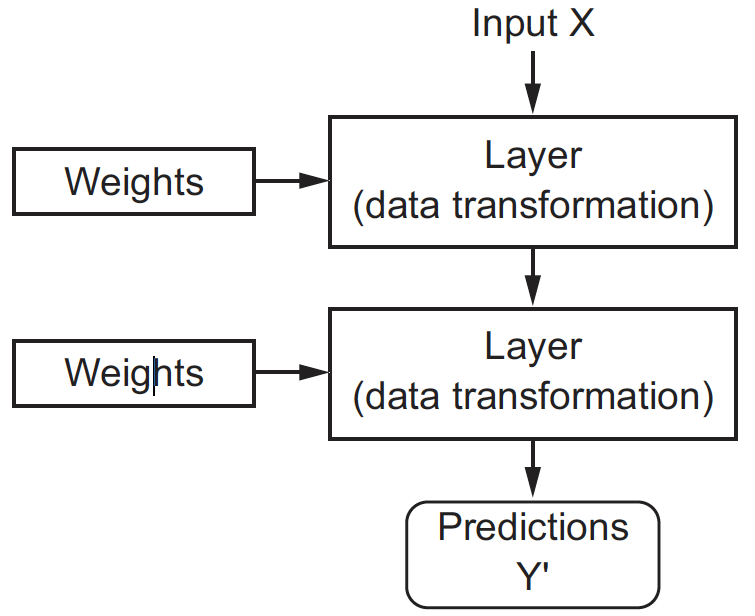

### Implementation details

In this tutorial, you will implement a network with two layers: the first one is a ReLU layer, whereas the second one is a softmax layer. In short, the network structure is *LINEAR -> RELU -> LINEAR -> SOFTMAX*. Note that the softmax layer returns a matrix whose rows can be interpreted as probability scores summing to 1. Hence, this network is useful for classification tasks. 

For a given input matrix $X$, the network output is computed as follows.

$$
\begin{aligned}
A^{[0]} &= X \\
A^{[1]} &= {\sf relu}\big(A^{[0]} W^{[1]} + {\rm b}^{[1]}\big)\\
A^{[2]} &= {\sf softmax}\big(A^{[1]} W^{[2]} + {\rm b}^{[2]}\big)\\
Y' &= A^{[2]}
\end{aligned}
$$

The size of matrices $W^{[i]}, {\rm b}^{[i]}, A^{[i]}$ depend on the following quantities.

- $N_{\rm samples}$ - Number of examples in your dataset.

- $N_{\rm input}\,\,$ - Length of each vector at the network input. **This is problem dependent.**

- $N_{\rm hidden}$ - Size of the first layer. This is chosen by the user.

- $N_{\rm output}$ - Size of the second layer. **This is problem dependent:** it must be equal to the number of classes in your dataset.

The dimensionality of all network's parameters are summarized below.

| .       | Shape of W | Shape of b | Shape of A |
|---------|------------|------------|------------|
| Input   | - | - | $N_{\rm samples}$ $\times$ $N_{\rm input}\,\,$ |
| Layer 1 | $N_{\rm input}$ $\times$ $N_{\rm hidden}$ | $1$ $\times$ $N_{\rm hidden}$ | $N_{\rm samples}$ $\times$ $N_{\rm hidden}$ |
| Layer 2 | $N_{\rm hidden}$ $\times$ $N_{\rm output}$ | $1$ $\times$ $N_{\rm output}$ | $N_{\rm samples}$ $\times$ $N_{\rm output}$ |


Before you can use the network, you need to randomly initialize the layer parameters $W^{[1]}, {\rm b}^{[1]}$ and $W^{[2]}, {\rm b}^{[2]}$. 

- The weight matrices $W^{[1]}$ and $W^{[2]}$ are initialized randomly to break symmetry, and make sure different units can learn different things. 
 
 
- In general, it is a bad idea to initialize all the weights to zero. Otherwise, every neuron in each layer would learn the same thing, resulting in a neural network that fails to break symmetry, and you might as well be training it with $N_{\rm hidden}=1$ (which is no more powerful than a linear model).  
 
 
- It is however okay to initialize the biases ${\rm b}^{[1]}$ and ${\rm b}^{[2]}$ to zeros. Symmetry is still broken so long as the weight matrices are initialized randomly. 


- Initializing the weight matrices to large random values does not work well. So, the important question is: how small should be these random values be? The answer (proposed in 2015) is to use a scaling factor of $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$. This approach works very well for layers with a ReLU activation. 


- A well chosen initialization can speed up the convergence of gradient descent, and increase the odds of converging to a lower generalization error.

### Quiz 3

> **Randomly initialize the layer parameters $W^{[1]}, {\rm b}^{[1]}$ and $W^{[2]}, {\rm b}^{[2]}$.**

> *Hints:*
>
> - Use random initialization for the weight matrices, such as `np.random.randn(nrows, ncols) * np.sqrt(2./nrows)`.
>
> - Use zeros initialization for the biases, such as `np.zeros((1, ncols))`.
>
> - Look at the table above to determine the correct shape of $W^{[1]}, {\rm b}^{[1]}$ and $W^{[2]}, {\rm b}^{[2]}$.

In [7]:
def initialize_parameters(n_input, n_hidden, n_output):
    """
    Arguments:
    n_input  -- Size of network input
    n_hidden -- Size of hidden layer (1st layer)
    n_output -- Size of network output (2nd layer)

    Returns:
    parameters -- array of arrays W1, b1, W2, b2
    """
    
    W1 = np.random.randn(n_input, n_hidden) * np.sqrt(2./n_input)
    b1 = np.zeros((1, n_hidden))
    W2 = np.random.randn(n_hidden, n_output) * np.sqrt(2./n_hidden)
    b2 = np.zeros((1, n_output))
    #print(f"W1:\n{W1}\nb1: {b1}\n\nW2:\n{W2}\nb2: {b2}\n")
    return W1, b1, W2, b2


In [8]:
np.random.seed(10)

n_input  = 5
n_hidden = 4
n_output = 3
W1, b1, W2, b2 = initialize_parameters(n_input, n_hidden, n_output)

assert_almost_equal(W1, [[ 0.8422,  0.4524, -0.9774, -0.0053],
                         [ 0.393 , -0.4554,  0.1679,  0.0687],
                         [ 0.0027, -0.1104,  0.2739,  0.7609],
                         [-0.6104,  0.6503,  0.1446,  0.2815],
                         [-0.7189,  0.0855,  0.9389, -0.6829]], decimal=4)

assert_almost_equal(b1, [[0., 0., 0., 0.]])

assert_almost_equal(W2, [[-1.3985, -1.2328,  0.1881],
                         [ 1.6864,  0.7946,  1.1827],
                         [ 0.0701,  0.9885, -0.1918],
                         [ 0.4336, -0.189 , -0.3884]], decimal=4)

assert_almost_equal(b2, [[0., 0., 0.]])


del n_input, n_hidden, n_output, W1, b1, W2, b2

### Quiz 4

> **Compute the output of a two-layer neural network.**

> *Hint:* 
> - You simply need to implement the pipeline *INPUT -> LAYER 1 -> LAYER 2 -> OUTPUT*
> - Reuse your previously implemented function `dense_layer`
> - Pick the correct activations: 
>   - **"relu" for the 1st layer,**
>   - **"softmax" for the 2nd layer.**

In [9]:
def twolayer_network(X, parameters):
    """
    Arguments:
    X -- input matrix of shape (n_samples, n_input)
    parameters -- W1, b1, W2, b2
    
    Returns:
    Y -- output matrix of shape (n_samples, n_output)
    """
    
    # Parameters
    W1, b1, W2, b2 = parameters
    
    # Forward propagation: INPUT -> LAYER 1 -> LAYER 2 -> OUTPUT
    A0 = X
    A1 = dense_layer(A0, W1, b1, activation='relu')
    A2 = dense_layer(A1, W2, b2, activation='softmax')

    #print(A2)
    
    return A2

In [10]:
np.random.seed(10)

n_input  = 5
n_hidden = 4
n_output = 3
params = initialize_parameters(n_input, n_hidden, n_output)

X = np.random.rand(10, n_input)

assert_almost_equal(twolayer_network(X, params), [[0.29287282, 0.47466353, 0.23246365],
                                                  [0.43291093, 0.29935568, 0.26773339],
                                                  [0.28229147, 0.37932587, 0.33838266],
                                                  [0.230469  , 0.59355683, 0.17597417],
                                                  [0.34380574, 0.21934467, 0.43684959],
                                                  [0.24427434, 0.2042511 , 0.55147457],
                                                  [0.45563539, 0.29954769, 0.24481692],
                                                  [0.41075115, 0.24857582, 0.34067303],
                                                  [0.3617473 , 0.26180309, 0.37644961],
                                                  [0.30082965, 0.23956349, 0.45960686]], decimal=4)

del n_input, n_hidden, n_output, params, X

## Cost function

Initially, the parameters of all layers are randomly initialized, so the network merely implements a series of random transformations. To control the output of a neural network, we need to be able to measure how far this output is from what you expected. This is the job of the loss function: it takes the network output and the true target (what you wanted the network to output) and computes a score expressing how bad the network has done on this specific example.

Choosing the right loss function for the right problem is extremely important, as a network will take any shortcut it can to minimize the loss. So, if the loss doesn’t fully correlate with success for the task at hand, our network will end up doing things you may not have wanted. Fortunately, when it comes to common problems such as classification and regression, there are simple guidelines we can follow to choose the correct loss:
 - **Cross entropy** for classification problems, 
 - **Mean squared error** for regression problems.
 
<!--![](../images/loss.png)-->

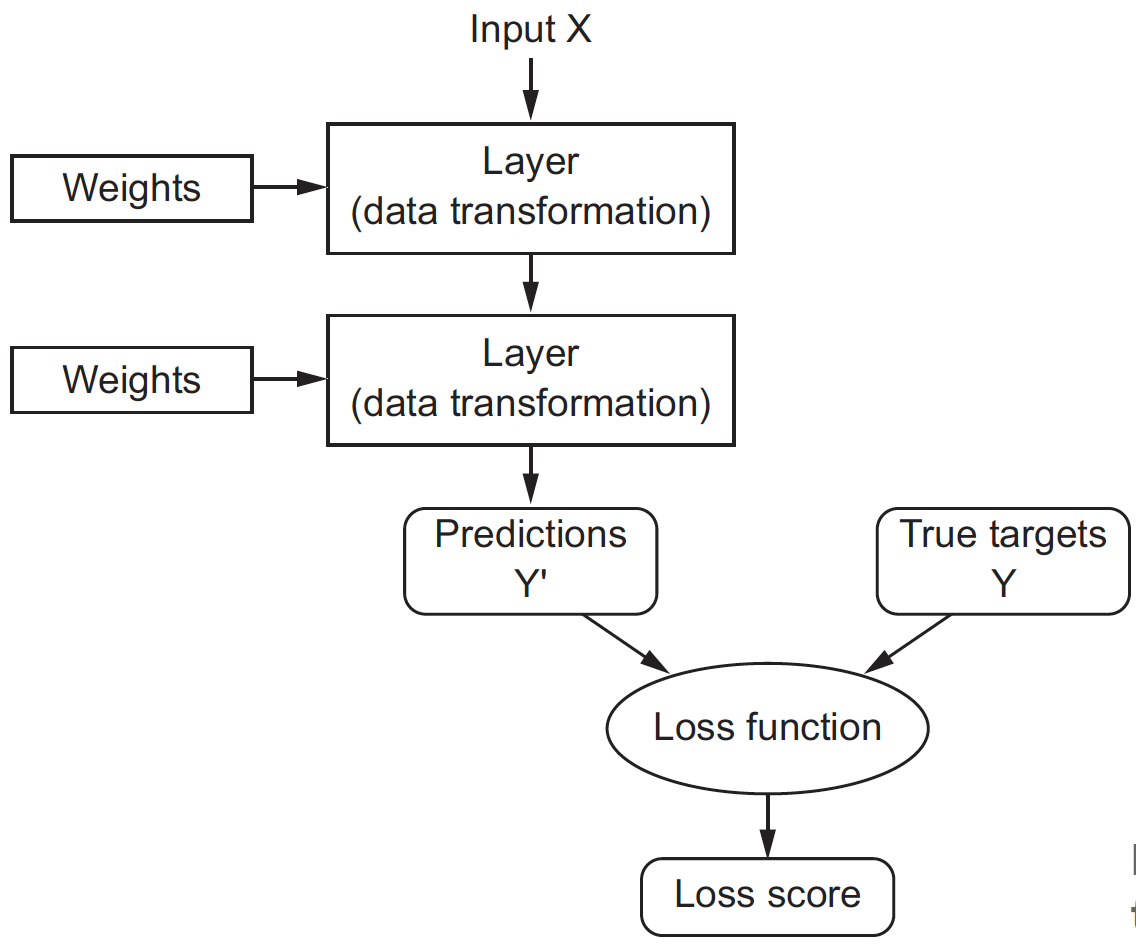

### Implementation details

So far, you have a network that takes an input matrix $X$ and returns an output matrix $\widehat{Y}$. Each row of the input matrix goes through the same computation *INPUT -> LAYER 1 -> LAYER 2 -> OUTPUT*, which produces the corresponding row of the output matrix.

$$
\widehat{Y} =
\begin{bmatrix}
\vdots\\
\_\!\_\; \widehat{\rm y}_n^\top \_\!\_ \\
\vdots\\
\end{bmatrix}
\in\mathbb{R}^{N_{\rm samples}\times N_{\rm output}}
$$

Your network is designed for classification tasks, as it ends with the softmax activation. The latter makes the coefficients of each output $\widehat{\rm y}_n$ sum to 1. These coefficients represent the probabilities that the corresponding input ${\rm x}_n$ belongs to a predefined set of classes $\{1,\dots,N_{\rm output}\}$. Ideally, you expect the network to predict the correct class with probability 1. This can be represented by a "one-hot" vector, whose coefficients are 0 everywhere, except the one associated to the expected class, which is equal to 1. For example, if the input ${\rm x}_n$ belongs to the class $c_n\in \{1,\dots,N_{\rm output}\}$, the expected output (i.e., the true target) is the one-hot vector ${\rm y}_n$ with the value $1$ in position $c_n$, that is

$$
{\rm y}_n = [0\;\dots\;0\underbrace{1}_{\textrm{class $c_n$}}0\;\dots\;0]^\top \in \mathbb{R}^{N_{\rm output}}.
$$

To control the output of your classification network, it is required that you convert the true classes of the input samples into one-hot vectors, and stack them into a matrix being the exact same size as the network output matrix.

$$
Y_{\rm true} =
\begin{bmatrix}
\vdots\\
\_\!\_\; {\rm y}_n^\top \_\!\_ \\
\vdots\\
\end{bmatrix}
\in\{0,1\}^{N_{\rm samples}\times N_{\rm output}}
$$

Now, the distance between the network outputs and the true targets can be computed with the **cross-entropy** loss function

$$
\textrm{cross-entropy}\big(\hat{Y},Y_{\rm true}\big) = \frac{1}{N_{\rm samples}}\!\sum_{n=1}^{N_{\rm samples}} \!-{\rm y}_n^\top\log\big(\widehat{\rm y}_n\big).
$$


### Quiz 5

> **Encode a vector of labels (from $0$ to $K-1$) into a matrix of one-hot rows.**

> *Example:*
> - Suppose you have the following vector of labels from $0$ to $6$.
```
labels = [1, 2, 6, 4]
```
> - Each label must be converted into a one-hot encoded vector, with the value $1$ in the position indicated by the label, and zero elsewhere:
```
labels[0] = 1  -->  one_hot[0] = [0, 1, 0, 0, 0, 0, 0]
labels[1] = 2  -->  one_hot[1] = [0, 0, 1, 0, 0, 0, 0]
labels[2] = 6  -->  one_hot[2] = [0, 0, 0, 0, 0, 0, 1]
labels[3] = 4  -->  one_hot[3] = [0, 0, 0, 0, 1, 0, 0]
```
> - Note that the length of the one-hot vectors is the max label plus one (6+1 = 7 in the above example). 

> *Hints:* 
> - Use `np.max()` to deduce $K$, the number of different labels.
>    - *Note:* $K-1$ is the maximum value that you will find in the label vector.
> - Use advanced indexing to write the value $1$ in the right positions of the one-hot matrix. To do this, you need two index vectors: 
>   - `idx1` contains the integers from `0` to `size`;
>   - `idx2` contains the labels to be encoded.

In [11]:
def to_categorical(labels):
    """
    Convert integers into one-hot vectors.
    
    Arguments:
    labels - vector of integers from 0 to C-1
    
    Returns:
    one_hot - matrix of shape (labels.size, C) with a one-hot encoded row for each element of 'labels'
    """
    
    # Number of elements in 'labels'
    size = labels.size
    
    # One plus the max value in 'labels'
    C = labels.max() + 1 
    
    # Create a zero matrix with the right shape
    one_hot = np.zeros((size, C), dtype=int)
    
    # Set the value 1 in the right positions
    idx1 = np.arange(size) 
    idx2 = labels.astype(int)
    one_hot[idx1, idx2] = 1
    
    return one_hot

In [12]:
labels1 = np.array([1, 1, 2, 1, 3, 6, 2, 4])
labels2 = np.array([1, 2, 0, 2, 4])

assert_almost_equal(to_categorical(labels1), [[0., 1., 0., 0., 0., 0., 0.],
                                              [0., 1., 0., 0., 0., 0., 0.],
                                              [0., 0., 1., 0., 0., 0., 0.],
                                              [0., 1., 0., 0., 0., 0., 0.],
                                              [0., 0., 0., 1., 0., 0., 0.],
                                              [0., 0., 0., 0., 0., 0., 1.],
                                              [0., 0., 1., 0., 0., 0., 0.],
                                              [0., 0., 0., 0., 1., 0., 0.]])

assert_almost_equal(to_categorical(labels2), [[0., 1., 0., 0., 0.],
                                              [0., 0., 1., 0., 0.],
                                              [1., 0., 0., 0., 0.],
                                              [0., 0., 1., 0., 0.],
                                              [0., 0., 0., 0., 1.]])

del labels1, labels2

### Quiz 6

> **Compute the cross entropy between the network output $\hat{Y}$ and the true targets $Y_{\rm true}$.**

> *Hint:* Multiply the two matrices element-wise, sum all the elements, and divide by the numer of samples.

In [13]:
def cross_entropy(Y, Y_true):
    """
    Arguments:
    Y -- network's output matrix of shape (n_samples, n_output)
    Y_true -- true target matrix of shape (n_samples, n_output)
    
    Returns:
    J -- scalar measuring the cross-entropy between Y and Y_true
    """
    # Compute cross-entropy loss
    J = -np.sum(Y_true * np.log(Y)) / Y.shape[0]
    
    return J

In [14]:
np.random.seed(10)

n_samples = 10
n_output  = 5

labels = np.random.randint(n_output, size=n_samples)
Y_true = to_categorical(labels)
Y      = np.random.rand(n_samples, n_output)

assert_almost_equal(cross_entropy(Y, Y_true), 1.2871054749330935, decimal=4)
print(cross_entropy(Y, Y_true))

del n_samples, n_output, labels, Y_true, Y

1.2871054749330935


## Training

Training a neural network consists of using the loss function as a feedback signal to adjust the layer parameters such that the network will correctly map the inputs to their expected targets. Let's discuss in more details how this happens concretely.

- You are given a set of input-output vectors describing a classification task. The output vectors are one-hot encoded.

$$
\mathcal{S} = \big\{ ({\rm x}_n,{\rm y}_n) \in\mathbb{R}^{N_{\rm input}}\times\mathbb{R}^{N_{\rm output}} \;|\; n=1,\dots,N_{\rm samples} \big\}
$$

- You have also defined a two-layer neural network. This is a function from $\mathbb{R}^{N_{\rm input}}$ to $\mathbb{R}^{N_{\rm output}}$, whose computation is controlled by the layer parameters $\theta=(W^{[1]},{\rm b}^{[1]},W^{[2]},{\rm b}^{[2]})$ according to the formula

$$ 
f_\theta({\rm x}) = {\sf softmax}\big({\sf relu}\big({\rm x}^\top W^{[1]} + {\rm b}^{[1]}\big) W^{[2]} + {\rm b}^{[2]}\big).
$$

- Your goal is to adjust the layer parameters $\theta$ such that the network output $f_\theta({\rm x}_n)$ is close to the expected output ${\rm y}_n$ for every training example $({\rm x}_n, {\rm y}_n)$. The cross entropy does a great job in measuring "how bad" the network has done on each specific example. Consequently, you want to

$$
\operatorname*{minimize}_{\theta} \underbrace{\sum_{n=1}^{N_{\rm samples}} \!\!-{\rm y}_n^\top \log\big(f_\theta({\rm x}_n)\big)}_{J(\theta)}.
$$


- What comes next is to gradually adjust the network parameters, based on the training data. To this end, you can take advantage of the fact that all operations used in the network are differentiable, and compute the gradient of the cross entropy with regard to the network parameters. You can then move the parameters in the opposite direction from the gradient to decrease the cross entropy, which boils down to
$$
\begin{aligned}
\\
\theta_{k+1} = \theta_k - \alpha \nabla J(\theta_k).\\
\\
\end{aligned}
$$
This gradual adjustment is basically the training that deep learning is all about. You will eventually end up with a network that has a very low cross-entropy on its training data. The network has “learned” to map its inputs to outputs that are as close as they can be to the correct targets.

<!--![](../images/training.png)-->

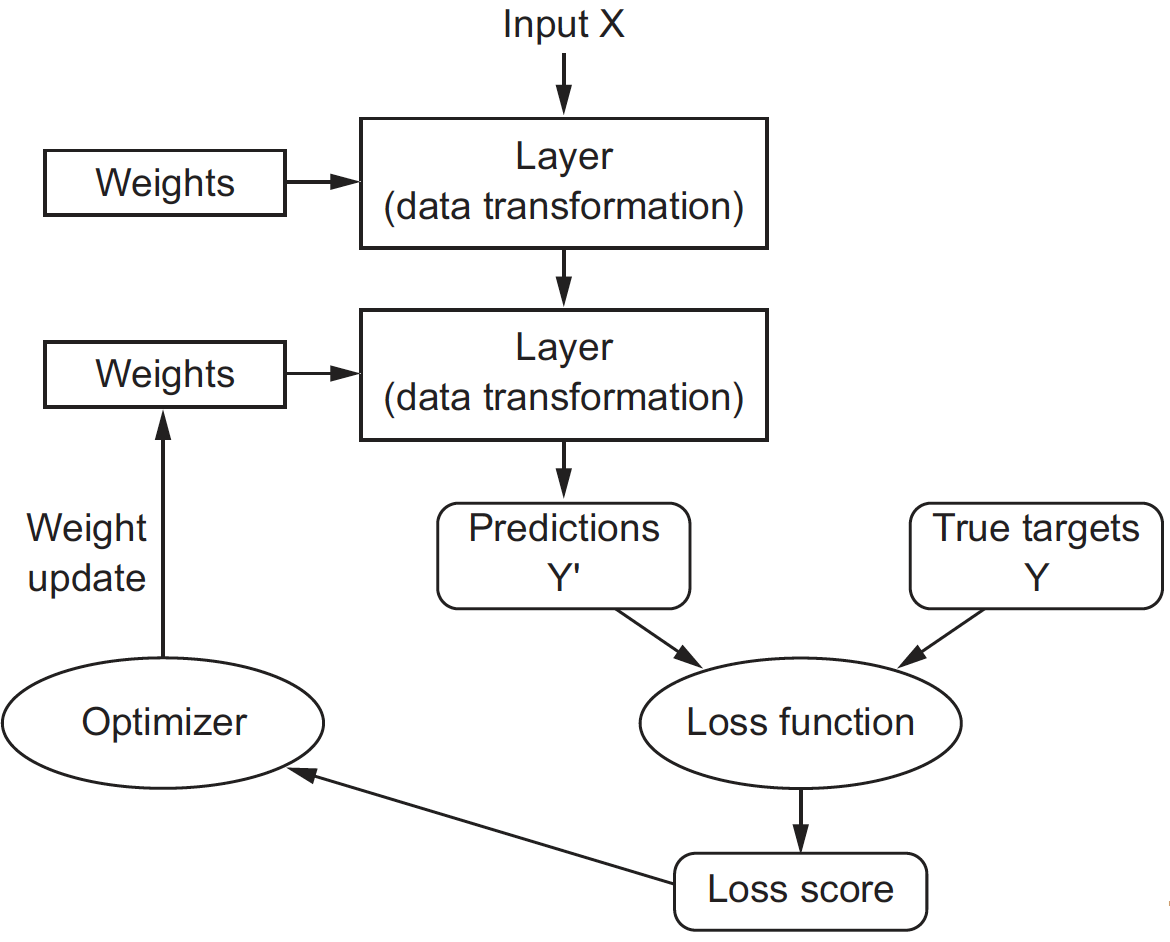

### Quiz 7

> **Define the cost function of your optimization problem**
>
> $$ J(\theta) = \frac{1}{N_{\rm samples}}\sum_{n=1}^{N_{\rm samples}} \!\!-{\rm y}_n^\top \log\big(f_\theta({\rm x}_n)\big). $$
>

> *Hints:* 
> - The arguments of this function are the set of weights $\theta$, the matrix of inputs ${\rm x}_n$, and the matrix of outputs ${\rm y}_n$.
> - Using the given parameters, the function runs the network on the inputs to obtain the predictions. 
> - Finally, it returns the cross entropy between the predictions and the true outputs.


In [15]:
def training_loss(parameters, X, Y):
    """
    Arguments:
    X -  input matrix of shape (n_samples, n_input)
    Y - output matrix of shape (n_samples, n_output)
    
    Returns:
    cost - cross entropy between the network predictions and the true outputs 
    """
    
    # Run the network on the inputs to obtain the predictions
    Y_pred = twolayer_network(X, parameters) 
    
    # Compute the cross entropy between the predictions and the true outputs
    cost = cross_entropy(Y_pred, Y)
    
    return cost

In [16]:
np.random.seed(42)

X, c = generate_data()
Y = to_categorical(c)

n_input  = X.shape[1]
n_output = Y.shape[1]
params = initialize_parameters(n_input, 10, n_output)

assert_almost_equal(training_loss(params, X, Y), 1.6300502421423746, decimal=4)

del X, c, Y, n_input, n_output, params

Now, you are ready to train the network via gradient descent.

<!--
# optimization (alternative code)
from autograd.misc.flatten import flatten_func
flat_cost, unflatten_func, flat_params = flatten_func(cost, params)
flat_params, history = gradient_descent(flat_cost, flat_params, alpha, epochs)
params = unflatten_func(flat_params)
-->

In [17]:
def training(X, Y, n_hidden, lr, epochs):
    """
    Arguments:
    X,Y      -- training data
    n_hidden -- Size of the hidden layer
    lr       -- learning rate
    epochs   -- n. iterations
    
    Returns:
    params -- optimized network parameters
    """
    from autograd.misc.optimizers import adam
    from autograd import grad
    
    # initialization
    n_input  = X.shape[1]
    n_output = Y.shape[1]
    params = initialize_parameters(n_input, n_hidden, n_output)

    # optimization
    cost_fun = lambda params, it: training_loss(params, X, Y)
    gradient = grad(cost_fun)
    history  = []
    tracker  = lambda params, it, g: history.append(cost_fun(params, it))
    params   = adam(gradient, params, step_size=lr, num_iters=epochs, callback=tracker)
    
    return params, history

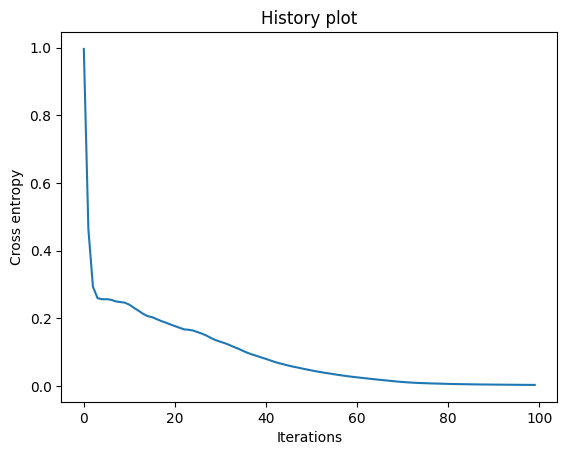

In [18]:
np.random.seed(42)

# dataset
X_train, c_train = generate_data()
Y_train = to_categorical(c_train)

# training
trained_params, history = training(X_train, Y_train, n_hidden=20, lr=0.1, epochs=100)

# history plot
plt.plot(history)
plt.title('History plot')
plt.ylabel('Cross entropy')
plt.xlabel('Iterations')
plt.show()

As you can see, the cross entropy decreases with every iteration. That's what you would expect when running gradient descent optimization.

## Prediction

After having trained a network, you will want to use it to make predictions. Remember that the network generates a vector of probabilities, each indicating how likely it is that the input belongs to one of the classes. Therefore, for a given input, the most probable class can be obtained as the  **maximum argument** of the probabilities returned by the network.

$$
\textrm{prediction}({\rm x}) = \arg\max f_\theta({\rm x})
$$

### Quiz 8

> **Run the network on the inputs, and returns the most probable class for each of them.**

> *Hint:* Remember that the network output is a matrix. You must operate along a single axis (which one?), not all the matrix.

In [19]:
def prediction(X, params):
    """
    Arguments:
    X -- input matrix of shape (n_samples, n_input)
    params -- W1, b1, W2, b2
    
    Returns:
    c -- prediction for each row of the input matrix 
    """
    
    # Run the network on the inputs
    Y = twolayer_network(X, params)
    # Compute the argmax of each probability vector
    c = np.argmax(Y, axis=1) 
    
    return c

In [20]:
np.random.seed(42)

X, c = generate_data()
Y = to_categorical(c)

n_input  = X.shape[1]
n_output = Y.shape[1]
params = initialize_parameters(n_input, 10, n_output)

assert_almost_equal(prediction(X, params), [2, 2, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2,
                                            1, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1,
                                            0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                                            2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                                            2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1,
                                            2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1,
                                            1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2])

del X, c, Y, n_input, n_output, params

In the moon dataset, the inputs are vectors of $\mathbb{R}^2$. A nice experiment for testing the capabilities of your trained network is to sample the $\mathbb{R}^2$ space over a fine grid, and predict the class of each point. The next figure shows the results of this experiment, where the sampled points are colored according to predicted class: blue for class 1, red for class 2, and green for class 3. You can see that the the network learned to correctly classify the training points. 

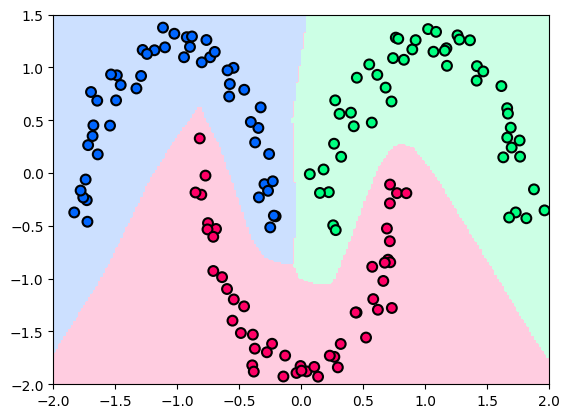

In [21]:
# input points (2D grid)
n = 200
xcoords, ycoords = np.meshgrid(np.linspace(-2, 2, n), np.linspace(-2, 1.5, n))
X_test = np.stack([xcoords.ravel(), ycoords.ravel()], axis=1)

# predictions
c_test = prediction(X_test, trained_params)

# visualization
zcoords = c_test.reshape(xcoords.shape)
show_data(X_train, c_train, (xcoords, ycoords, zcoords))

It is also interesting to analyze the boundaries between the colored regions. If you go back and train your network with a different value of `n_hidden` (the size of the hidden layer), you will see different region boundaries. Smaller values will lead to straighter lines, whereas bigger values will result in more bent curves. This is not surprising, as the number and the size of layers in a network affect its capacity to learn complex patterns from the training data.

## Handwritten digit classification

Now that you grasped the key concepts of deep learning, you can focus on a more concrete classification task. In the following, you will work with the MNIST dataset, which contains a set of 60,000 training images, and a set of 10,000 test images. Your goal is to train a neural network for classifying images of handwritten digits (28 pixels by 28 pixels) into their 10 categories (0 to 9). 

In [22]:
from data.utils import load_mnist

(raw_train_images, raw_train_labels), (raw_test_images, raw_test_labels) = load_mnist('data')

The images are represented as matrices, and they are all stacked into a Numpy array of shape `(num_images, 28, 28)`. Each image is associated to a label ranging from 0 to 9, and all the labels are gathered into a vector being the same length as the number of available images. These two arrays describe the handwritten digit classification task, and they constitute the data on which you will train/test your network.

In [23]:
print('Image array (training):', raw_train_images.shape)
print('Label array (training):', raw_train_labels.shape)
print('\nImage array (test):', raw_test_images.shape)
print('Label array (test):', raw_test_labels.shape)

Image array (training): (60000, 28, 28)
Label array (training): (60000,)

Image array (test): (10000, 28, 28)
Label array (test): (10000,)


Let's have a look at a small batch of data, constisting of both images and labels.

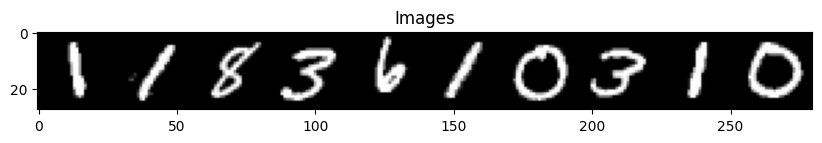

Labels: [1 1 8 3 6 1 0 3 1 0]


In [24]:
n = 20 # change this number to display a different batch

batch_size = 10
inputs = raw_train_images[n*batch_size : (n+1)*batch_size,:,:]
labels = raw_train_labels[n*batch_size : (n+1)*batch_size]

plt.figure(figsize=(10,5))
plt.imshow(np.hstack([inputs[i,:,:] for i in range(inputs.shape[0])]), cmap='gray')
plt.title("Images")
plt.show()
print("Labels: " + str(labels))

You usually need to preprocess your data before training. This consists of reshaping the data arrays into the shape expected by the network, and scaling them so that all values are in  the `[0, 1]` interval. In MNIST dataset, the images are stored in two arrays of shape `(num_images, 28, 28)` of type `uint8` with  values in the `[0, 255]` interval. You will transform them into `float` arrays of shape `(num_images, 28 * 28)` with values between 0 and 1.

In [25]:
train_images = raw_train_images.reshape(60000, 28 * 28) / 255
test_images  = raw_test_images.reshape(10000, 28 * 28) / 255

You also need to categorically encode the labels, which consists of transforming integers into "one-hot" vectors. Here are some exemples.

$$
\begin{aligned}
0 &\quad\to\quad [1\;0\;0\;0\;0\;0\;0\;0\;0\;0] \\
1 &\quad\to\quad [0\;1\;0\;0\;0\;0\;0\;0\;0\;0] \\
2 &\quad\to\quad [0\;0\;1\;0\;0\;0\;0\;0\;0\;0] \\
&\quad\;\,\vdots\\
8 &\quad\to\quad [0\;0\;0\;0\;0\;0\;0\;0\;1\;0] \\
9 &\quad\to\quad [0\;0\;0\;0\;0\;0\;0\;0\;0\;1] 
\end{aligned}
$$

This step is only required in multi-class classification, as the cross entropy expects the labels to be one-hot encoded.

In [26]:
train_labels = to_categorical(raw_train_labels)
test_labels  = to_categorical(raw_test_labels)

In [27]:
print('Image array (training):', train_images.shape)
print('Label array (training):', train_labels.shape)
print('\nImage array (test):', test_images.shape)
print('Label array (test):', test_labels.shape)

Image array (training): (60000, 784)
Label array (training): (60000, 10)

Image array (test): (10000, 784)
Label array (test): (10000, 10)


## Stochastic gradient descent

Having a good optimization algorithm can be the difference between waiting days versus just a few hours to get a good result. In this regard, "stochastic" gradient descent is a variant of the gradient method that can speed up learning, and perhaps even get you to a better final value for the cost function. What change is that you would be computing gradients on just few training examples at a time, rather than on the whole training set. This requires two ingredients.

- **Shuffling**: Create a shuffled version of the training set $X, Y$ by randomly permuting their rows. This random shuffling is done synchronously between $X$ and $Y$, so that after the shuffling the $n^{th}$ row of $X$ is the example corresponding to the $n^{th}$ label in $Y$. Shuffling ensures that examples will be split randomly into different mini-batches. 


- **Partition**: Divide the shuffled $X, Y$ into small batches of rows, as shown below (matrices are transposed for visualization purposes). Note that the number of training examples is not always divisible by the batch size, in which case the last batch might be smaller.


<!--![](../images/mini_batches.png)-->

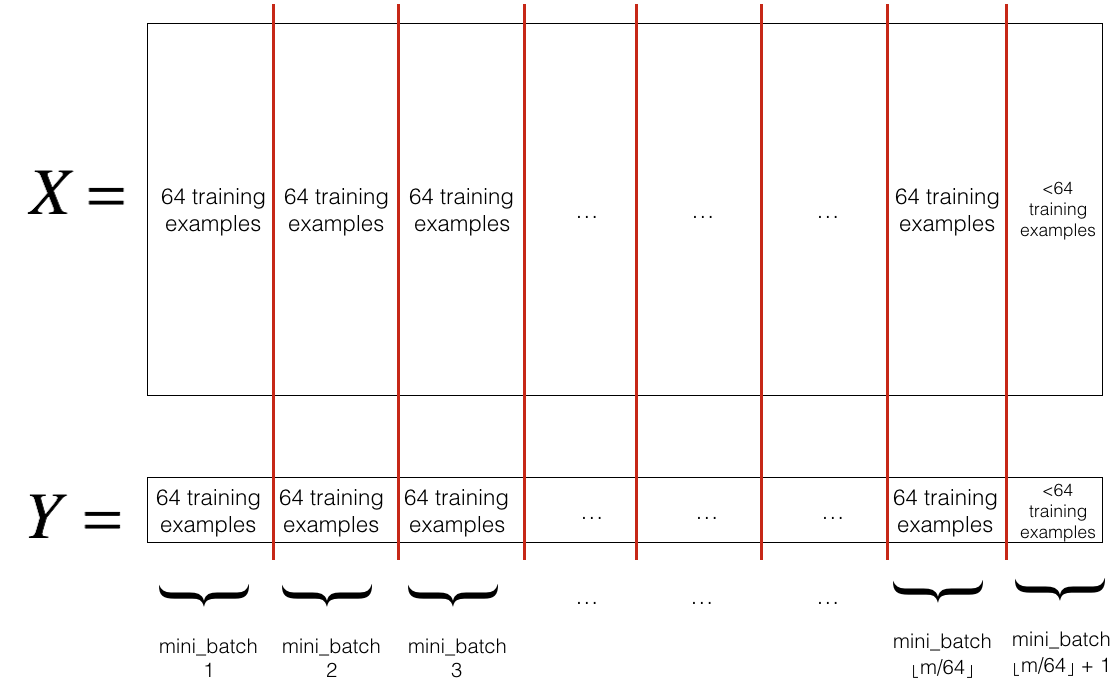

### Quiz 9

> **Define a "stochastic" version of the cost function**
>
> $$ J(\theta) = \frac{1}{N_{\rm samples}}\sum_{n=1}^{N_{\rm samples}} \!\!-{\rm y}_n^\top \log\big(f_\theta({\rm x}_n)\big). $$
>
>
> Concretely, you will implement this as a python class with several methods.
> - `__init__()` is the constructor. It takes the matrix of inputs ${\rm x}_n$, the matrix of outputs ${\rm y}_n$, and the predefined batch size. Using this information, it computes the total number of batches by which the dataset can be divided.
>
> - `setup()` divides the dataset in small batches.
>
> - `__call__()` is the cost function. It draws a batch of inputs and corresponding outputs, runs the network on the inputs to obtain the predictions, and returns the cross entropy between the predictions and the true outputs.
>
> - `get_batch()` extract a batch from the dataset.
>
> - `shuffle()` handles the dataset shuffling.
>
> - `tracker()` visualizes a progress bar during training.

> *Hint:* To help you with the partitioning, we give you the following code that defines the indexes for the first and second batches:
>
> ```python
indices_of_1st_batch = slice(0, self.batch_size)
indices_of_2nd_batch = slice(self.batch_size, 2 * self.batch_size)
...
>```

In [28]:
class StochasticOptimizationProblem:
    
    def __init__(self, X, Y, batch_size):
        self.X = X
        self.Y = Y
        self.total = X.shape[0]
        self.batch_size = batch_size
        self.num_batches = int(np.ceil(self.total / batch_size))
        self.setup()
        self.history = []
        
    #----- BEGIN QUIZ -----#
    
    def setup(self):
        self.batches = []
        for n in range(self.num_batches):
            # index slice for the n-th batch
            idx =  slice(n*self.batch_size, (n + 1)*self.batch_size)
            self.batches.append(idx)
    
        
    def __call__(self, params, iteration):
        
        # extract the current batch
        X, Y = self.get_batch(iteration)
        
        # run the network on the batch
        Y_pred = twolayer_network(X, params)
        
        # compute the cross entropy
        cost = cross_entropy(Y_pred, Y)
        
        # save it for later
        self.history.append(cost if isinstance(cost, float) else cost._value)
        
        return cost
    
    #----- END QUIZ -----#
    
    def get_batch(self, iteration):
        num = iteration % self.num_batches
        idx = self.batches[num]
        if num == 0: self.shuffle()
        return self.X[idx], self.Y[idx]
    
    def shuffle(self):
        idx = np.random.permutation(self.total)
        self.X = self.X[idx]
        self.Y = self.Y[idx]
        
    def tracker(self, params, it, g):
        if (it % (self.num_batches//20)) == 0:
            count = round(it / self.num_batches * 10)
            print("Training: [%-20s]" % ('='*(count//5)), "%d%%" % count, end="\r")

In [29]:
np.random.seed(42)

X, c = generate_data()
Y = to_categorical(c)

n_input  = X.shape[1]
n_output = Y.shape[1]
params = initialize_parameters(n_input, 10, n_output)

cost_fun = StochasticOptimizationProblem(X, Y, batch_size=60)

assert_almost_equal([cost_fun(params,i) for i in range(4)], 
                    [1.7891351888666946, 1.5911320535591584, 1.389716725860166, 1.596359732370145], decimal=4)

Now, you are ready to train the network via stochastic gradient descent.

In [30]:
def stochastic_training(X, Y, n_hidden, lr, epochs, batch_size):
    """
    Arguments:
    X,Y        -- training data
    n_hidden   -- size of the hidden layer
    lr         -- learning rate
    epochs     -- n. iterations
    batch_size -- split size of the dataset 
    
    Returns:
    params -- optimized network parameters
    """
    from autograd.misc.optimizers import adam
    from autograd import grad
        
    # initialization
    n_input  = X.shape[1]
    n_output = Y.shape[1]
    params = initialize_parameters(n_input, n_hidden, n_output)
    
    # optimization
    cost     = StochasticOptimizationProblem(X, Y, batch_size)
    gradient = grad(cost)
    params   = adam(gradient, params, step_size=lr, num_iters=epochs * cost.num_batches, callback=cost.tracker)
    
    return params, cost.history

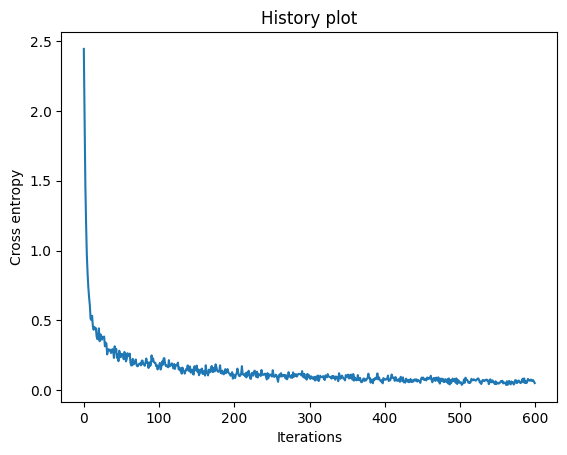

In [31]:
np.random.seed(42)

# training
trained_params, history = stochastic_training(train_images, train_labels, n_hidden=50, 
                                              lr=0.01, epochs=10, batch_size=1000)
# history plot
plt.plot(history)
plt.title('History plot')
plt.ylabel('Cross entropy')
plt.xlabel('Iterations')
plt.show()

As you can see in the history plot, the cross entropy eventually converges to a small value. However, it does **not always** decrease with every iteration. That's what you would expect when running stochastic gradient descent.

## Validation

After having trained the network, you will want to use it for making predictions. Remember that the network generates a vector of probabilities, each indicating how likely it is that an image belongs to one of the 10 digit classes. The largest entry is the predicted class, as it is the class with the highest probability. The figure below displays the predicted probabilites for a batch of test images.

In [32]:
test_probas = twolayer_network(test_images, trained_params)

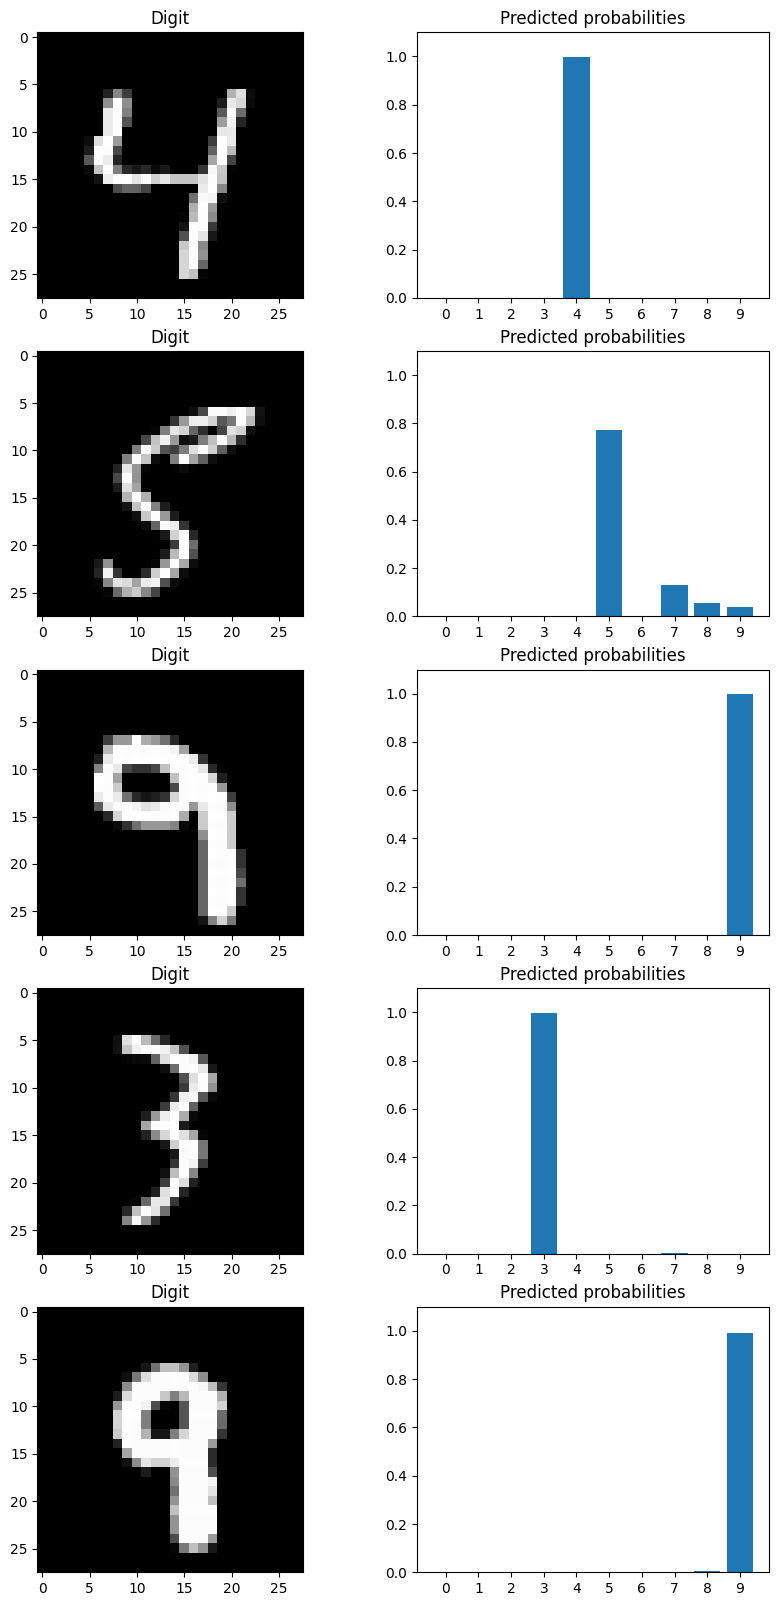

In [33]:
n = 42
batch_size = 5

inputs  = test_images[n*batch_size : (n+1)*batch_size,:].reshape(batch_size, 28, 28)
outputs = test_probas[n*batch_size : (n+1)*batch_size,:]

f, ax = plt.subplots(batch_size,2, figsize=(10,4*batch_size))
for i in range(batch_size):
    ax[i,0].imshow(inputs[i,:,:], cmap='gray')
    ax[i,0].set_title("Digit")
    ax[i,1].bar(range(10), outputs[i,:])
    ax[i,1].set_title("Predicted probabilities")
    ax[i,1].set_xticks(range(10))
    ax[i,1].set_ylim((0,1.1))
    
plt.show()

Now, check how the network performs on the test set. The accuracy should be around 97%.

In [34]:
test_preds = test_probas.argmax(axis=1)

accuracy = np.mean(test_preds == raw_test_labels)

print('Test accuracy: {:2.2f}%'.format(accuracy*100))


Test accuracy: 97.11%


## Handwritten digit recognition

You will now build an algorithm for handwritten digit recognition. The workflow consists of the following steps. 

 - Take an image.

 - Find all the handwritten digits.

 - Run the trained network on the found digits, and display the predicted classes.

### Quiz 10

> **Preprocess a list of digit images, and run the network on them to predict their classes.**

In [35]:
import cv2
from data.digits import find_digits

def digit_recognition(image_name):
    
    # Digit extraction
    image = cv2.imread(image_name)
    digits, rects = find_digits(image)

    # Preprocessing: reshape and normalize the digits
    digits = digits.reshape(digits.shape[0], 28*28) 
    digits = digits.astype('float32')/255
    print(digits.shape)

    # Network prediction: classify the digits
    
    labels = prediction(digits, trained_params)        

    # Visualization
    plt.figure(figsize=(8,8))
    for tag, rect in zip(labels, rects):
        cv2.rectangle(image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3)
        cv2.putText(image, str(tag), (rect[0], rect[1]-5), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 0, 0), 3)
    plt.imshow(image)
    plt.show()

Now, test your network on some real pictures of handwritten digits. 

(8, 784)


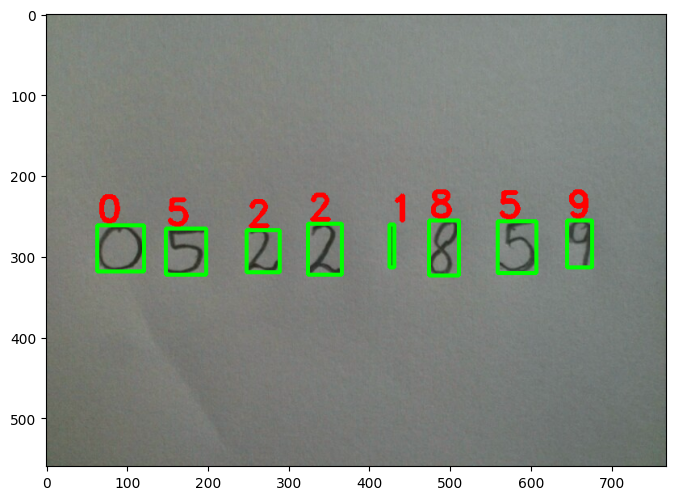

In [36]:
digit_recognition("data/photo1.jpg")

(24, 784)


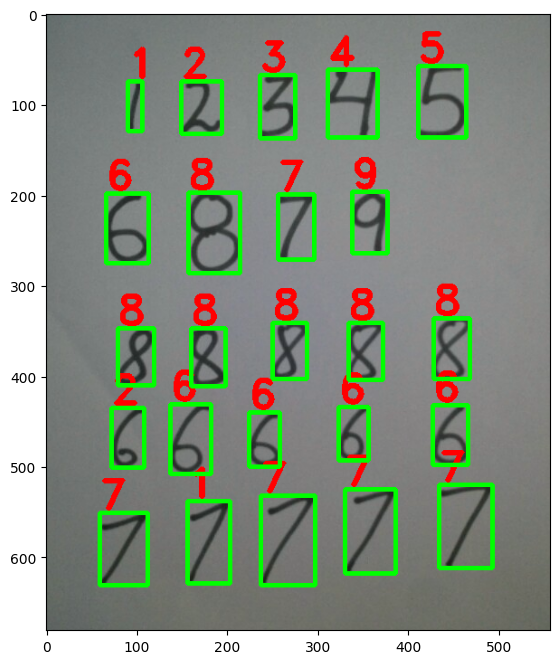

In [37]:
digit_recognition("data/photo2.jpg")

(24, 784)


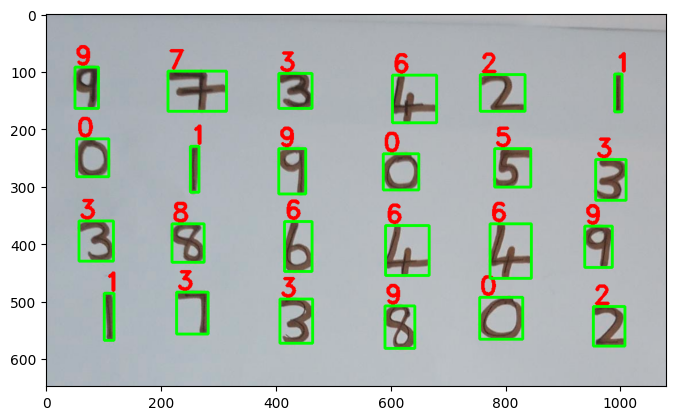

In [38]:
digit_recognition("data/photo3.jpg")

## Additional functionality

Congratulations! You finished the first part of this assignment, where you built and trained a two-layer neural network. As mentioned in the introduction, completing the first 10 exercises earns you 12 points (out of 20). You are encouraged to implement additional functionality if you wish to get more points. But you will be on your own henceforth. Read below to uncover your next steps.

### Quiz 11

Modify your code to implement a multilayer neural network. The number of layers, the size and the activation of each layer must be fully customizable. Here are some hints to get started.


- `dense_layer()` – Modify this function to add new activations, such as *tanh*, *leaky ReLU*, *ELU*, and *SELU*.


- `initialize_parameters()` – Modify this function to return the parameters `(W1, b1, W1, b2, …, Wl, bl)` of a multilayer neural network.


- `dropout()` - Create this function to implement a dropout layer. See the slides of lecture 4 for more details.


- `multilayer_network()` - Create this function to compute the output of a multilayer neural network.


- `StochasticOptimizationProblem` - You will need to modify this class.


- `stochastic_training()` – You will need to modify this function.

You are free to reorganize and redesign the code as you see fit. You can take inspiration from `PyTorch` if you want to take on the challenge of refactoring all the codebase. This will earn you additional points in the final grade. However, you are not compelled to do any software engineering work.

### Quiz 12

Extend your code to implement the "LeNet-5" convolutional neural network. Here are some hints to get started.


- `convolution_layer()` – Define this function to implement the convolutional layer. It computes `outputs = relu(convolve(inputs, filters) + bias)`using the function `np.scipy.signal.convolve` provided by Autograd. The description of this function is available [here](https://github.com/HIPS/autograd/issues/309). 


- `pooling_layer()` – Define this function to implement the max-pooling layer. Here is a simple example in numpy that computes the max-pooling of a 2D array
```python
n, m = data.shape
data = data.reshape(n, m//2, 2).max(axis=-1)
data = data.reshape(n//2, 2, m//2).max(axis=-2)
```
Adjust `reshape` and `axis` to work on 4D arrays: (n, d, h, w) —> (n, d, h/2, w/2).


- `flatten_layer()` – Define this function to implment a dummy layer that reshapes a 4D array of shape (n_images, depth, height, width) into a 2D array of shape (n_images, depth * height * width). This layer must arrive just before the first fully-connected layer.


- `initialize_parameters()` – Modify this function to return the parameters of "LeNet-5" network. Remember the following.
   - **Convolution layer**
      - *Input:* Array of shape (n_images, depth, height, width)
      - *Weights:* Array of shape (depth, n_filters, filter_size, filter_size)
      - *Bias:* Array of shape (1, n_filters, 1, 1)
      - *Output:* Array of shape (n_images, n_filters, height, width)
   - **Pooling layer**
      - *Input:* Array of shape (n_images, depth, height, width)
      - *Output:* Array of shape (n_images, depth, height/2, width/2)
      - No parameters
   - **Flatten layer**
      - *Input:* Array of shape (n_images, depth, height, width)
      - *Sortie:* Array of shape (n_images, depth * height * width)
      - No parameters.


- `convolutional_network()` – Define this function to compute the output of "LeNet-5" network. Remark the following
   - The input of a convolutional network is a 4D array of shape (n_images, depth, height, width). 
   - The size of MNIST dataset should be (n_images, 1, 28, 28), where n_images is the number of images used for training/testing. 


- `StochasticOptimizationProblem` – You will need to modify this function.


- `stochastic_training()` – You will need to modify this function.


If you are lost at some point and don't know how to proceed, take a look at [**this example**](https://github.com/HIPS/autograd/blob/master/examples/convnet.py) provided by Autograd.


